# SD211  TP3 - Restauration d'image à l'aide de l'ADMM

### Yanting LI

## Introduction

Il s'agit d'un problème de restauration d'image dans le contexte de minimisation à l'aide de l'algorithm ADMM.<br>
Quelques explications:<br>
 - La matrice ${\bf X} \in {\cal R}^{K \times L}$ est l'image 2D original, où K = L = 64. On notera P = K × L le nombre total de pixels dans l'image;<br>
 - ${\bf Y} \in {\cal R}^{K \times L}$ représente l'observation en 2D qui est généré par ${\bf Y} = {\cal H} * {\bf X}$, où ${\cal H} \in {\cal R}^{M \times N}$ est la réponse spatiale du filtre de flou de bougé.<br>
 
Pour exprimer le produit de concolution, on vectorise l'image original et l'observation comme ci dessous:
$${\bf y} = {\bf Hx}$$
 - ${\bf H} \in {\Bbb R}^{P \times P}$ est la matrice de convolution traduisant l'opération de convolution par ${\cal H}$ après vectorisation de l'image.


## 1 Altération d'un image

In [93]:
import pickle
from PIL import Image
import numpy as np
from scipy.sparse import linalg
from scipy import sparse
import matplotlib.pyplot as plt
from time import time
from __future__ import division
import sys

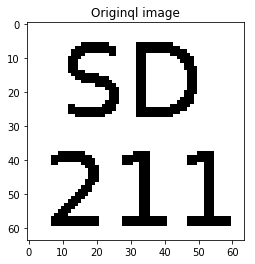

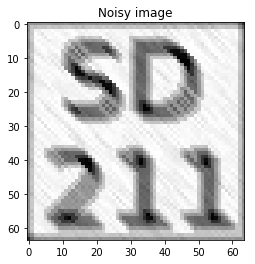

In [177]:
# Open the data stored in a .pk file
data = pickle.load(open('dataforpython2.pk', 'rb'))

H = data.get('H').toarray()
T = data.get('T')
observations = data.get('observations')
original = data.get('original')

plt.imshow(original, cmap='gray')
plt.title('Originql image')
plt.show()
plt.imshow(observations, cmap='gray')
plt.title('Noisy image')
plt.show()

## 2 Restauration d'image
Problème:
$$\min_{x}  \frac{1}{2}||{\bf y} -{\bf Hx}||^{2}_{2} + \beta ||{\bf Tx}||_{1} + {\bf \iota}_{[0,1]^{P}}({\bf x})$$

où 
$$||{\bf Tx}||_{1} = \sum_{i,j} (|{\bf X}[i+1,j] - {\bf X}[i,j]| + |{\bf X}[i,j+1] - {\bf X}[i,j]|)$$


La matrice ${\bf T} \in {\Bbb R}^{(2P-K-L)\times P}$ représente les décalages horizontaux et verticaux. 

### Préparation 1
Sachant que 
${\bf z}_{1} = {\bf x}$, ${\bf z}_{2} = {\bf Tx}$ et ${\bf z} = [{\bf z}_{1}^{T}, {\bf z}_{2}^{T}]^{T}$,  pour transformer l'problème ci-dessus à le problème d'optimisation
$$\min_{x} f({\bf x}) + g({\bf z})$$
$$s.t.  {\bf Ax} = {\bf z}$$

On a 

$$f({\bf x}) = \frac{1}{2} ||{\bf y}-{\bf Hx}||^{2}_{2}$$

$$g({\bf z}) = 
    \begin{bmatrix} \iota_{[0,1]^{P}} & 0 \\ 0 & \beta {\bf I}_{(2P−K−L)} \\ \end{bmatrix}
  {\bf z}
$$
où $\iota_{[0,1]^{P}} \in {\cal R}^{P \times P}$
$${\bf z} = {\bf Ax}  $$
$${\bf A} =
\begin{pmatrix} {\bf I}_{P} \\ {\bf T} \\ \end{pmatrix}
$$

### Préparation 2
Le problème (3) s'écrit:<br>
$$\min_{{\bf x}, {\bf z_{2}}} 
  \frac{1}{2}||{\bf y} - {\bf Hx}||^{2}_{2} + \beta ||{\bf z_{2}}||_{1}
  $$
 
$$s.t. {\bf Tx} = {\bf z_{2}}$$

Le Lagrangien augmenté s'écrit:<br>
$$ {\cal L}_{\rho}({\bf x}^{k},{\bf z}^{k};{\bf \gamma}^{k}) = 
    \frac{1}{2}||{\bf y} - {\bf Hx}||^{2}_{2} + \beta ||{\bf z_{2}}||_{1} + {\bf \iota}_{[0,1]^{P}}({\bf z}_{1})
    + <{\bf \gamma}^{k}, {\bf Tx} - {\bf z}_{2}> + \frac{\rho}{2}||{\bf Tx} - {\bf z}_{2}||^{2}_{2}
$$

### Préparation 3
Algorithme ADMM:<br>
$${\bf x}^{k+1} = \arg\min_{\bf x} {\cal L}_{\rho}({\bf x},{\bf z}^{k} , \gamma^{k})$$

$${\bf z}^{k+1} = [{\bf z}^{k+1}_{1}, {\bf z}^{k+1}_{2}]^{T}$$
$$= \arg\min_{\bf z} {\cal L}_{\rho}({\bf x}^{k+1},{\bf z} , \gamma^{k})$$

$${\bf \gamma}^{k+1} = \gamma^{k} + \rho({\bf Ax}^{k+1} - {\bf z}^{k+1})$$

L'étape de minimisation de ${\cal L}_{\rho}$ selon la variable ${\bf x}$:<br>
$$x^{k+1} = \arg\min_{\bf x}  
    f(x) + g(z^{k}) + <\gamma^{k}, Ax-z^{k}> + \frac{\rho}{2}||Ax-z^{k}||^{2}
$$

$$ = \arg\min_{\bf x} \frac{1}{2}||Hx-y||^{2} + <\gamma^{k}, Ax> + \frac{\rho}{2}||Ax-z^{k}||^{2}$$

$$0 = H^{T}(Hx-y) + A^{T}\gamma^{k} + \rho A^{T}(Ax-z^{k})$$

$$\implies x^{k+1} = (H^{T}H + \rho A^{T}A)^{-1} (H^{T}y + \rho A^{T}z^{k} - A^{T}\gamma^{k})$$

### Préparation 4
Pour $z_{1}$:<br>

$$z^{k+1}_{1} = \arg\min_{z_{1}} 
    f(x^{k+1}) + g(z_{1}) + <\gamma_{1}^{k}, I_{P}x^{k+1} - z_{1}> + \frac{\rho}{2}||I_{P}x^{k+1} - z_{1}||^{2}
    $$
$$ = \arg\min_{z_{1}}\iota_{[0,1]^{P}}(z_{1}) - <\gamma_{1}^{k}, z_{1}> + \frac{\rho}{2}||I_{P}x^{k+1} - z_{1}||^{2}$$

$$ = \arg\min_{z_{1}} \frac{\rho}{2} ||z_{1} - x^{k+1}||^{2} - \gamma_{1}^{kT}z_{1} + \iota_{[0,1]^{P}}(z_{1})$$

$$ = proj_{\iota_{[0,1]^{P}}} (x^{k+1} + \frac{\gamma_{1}^{k}}{\rho})$$

$$ z^{k+1}_{1} = 
    \begin{cases}
    0,  & \text{if $x^{k+1} + \frac{\gamma_{1}^{k}}{\rho} \leq 0$} \\
    x^{k+1} + \frac{\gamma_{1}^{k}}{\rho}, & \text{if $0 < x^{k+1} + \frac{\gamma_{1}^{k}}{\rho} < 1$} \\
    1,  & \text{if $x^{k+1} + \frac{\gamma_{1}^{k}}{\rho} \geq 1$}
\end{cases}$$

Pour $z_{2}$:<br>
$$z_{2}^{k+1} = \arg\min_{z_{2}} \beta ||z_{2}||_{1}
    + <\gamma_{2}^{k}, z_{2}> + \frac{\rho}{2}||Tx^{k+1} - z_{2}||^{2}_{2}$$
   
$$ = prox_{\frac{1}{\rho} g} (Tx^{k+1} + \frac{\gamma_{2}^{k}}{\rho}) $$
$$= S(Tx^{k+1} + \frac{\gamma_{2}^{k}}{\rho})$$

$$ z^{k+1}_{2} = 
    \begin{cases}
    Tx^{k+1} + \frac{\gamma_{2 i}^{k}}{\rho} - \frac{\beta}{\rho},  & \text{if $Tx^{k+1} + \frac{\gamma_{2 i}^{k}}{\rho}> \frac{\beta}{\rho}$} \\
    0, & \text{if $Tx^{k+1} + \frac{\gamma_{2 i}^{k}}{\rho} \in [-\frac{\beta}{\rho}, \frac{\beta}{\rho}]$} \\
    Tx^{k+1} + \frac{\gamma_{2 i}^{k}}{\rho} + \frac{\beta}{\rho},  & \text{if $Tx^{k+1} + \frac{\gamma_{2 i}^{k}}{\rho} < -\frac{\beta}{\rho}$}
\end{cases}$$

### Préparation 5
$$\gamma_{1}^{k+1} = \gamma_{1}^{k} + \rho (x^{k+1} - z_{1}^{k+1})$$

$$\gamma_{2}^{k+1} = \gamma_{2}^{k} + \rho (Tx^{k+1} - z_{2}^{k+1})$$


## 3 Implémentation de l'ADMM pour résoudre le problème de restauration d'image
Paramètres de l'ADMM:<br>
 - $\rho = 0.05$
 - $\beta = 0.01$
 - $k_{max} = 100$<br>
 
### Manipulation 2 & 3

In [121]:
# Prepare data:
rho = 0.05
beta = 0.01
k_max = 100
# Get the size of the image
K,L = observations.shape
P = K*L
# Observation, Original, T, A:
y = np.ravel(observations)
x_orig = np.ravel(original)
x0 = np.ones(x_orig.shape[0])
I = np.eye(x_orig.shape[0], dtype=int)
T = data.get('T').toarray()
A = np.vstack((I, T))

In [151]:
# definie positive?
C = np.linalg.eigvals(H.T.dot(H) + rho*A.T.dot(A))
print "La matrice est definie positive: ",np.all(C>0)

La matrice est definie positive:  True


In [178]:
def ADMM(x0,y,rho=0.05,beta=0.01,k_max=100):
    '''x(4096,)   z1(4096,)   z2(8064,)   z(12160,)'''
    j = ''
    value = []
    X = []
    EQMs = []
    Biais = []
    z1 = x0
    z2 = T.dot(x0)
    z = np.hstack((z1,z2))
    gamma1 = np.zeros(z1.shape[0])
    gamma2 = np.zeros(z2.shape[0])
    gamma = np.hstack((gamma1,gamma2))
    inv = np.linalg.inv((H.T.dot(H) + rho*(A.T).dot(A)))
    for i in range(k_max):
        # Process Bar:
        j += '#'
        sys.stdout.write(str(int((i/99)*100))+'%  ||'+j+'->'+"\r")
        sys.stdout.flush()
        # function value, x, z, gamma for each iteration:
        x = inv.dot(H.T.dot(y)+rho*A.T.dot(z)-A.T.dot(gamma))
        val = 0.5*np.sum((y-H.dot(x))**2) + beta*np.sum(np.abs(T.dot(x)))
        biais = x - x_orig
        EQM = np.mean((x-x_orig)**2)
        z1 = proj(x + gamma1/rho)
        z2 = Soft(T.dot(x) + gamma2/rho, beta/rho)
        z = np.hstack((z1,z2))
        gamma1 = gamma1 + rho*(x - z1)
        gamma2 = gamma2 + rho*(T.dot(x) - z2)
        gamma = np.hstack((gamma1,gamma2))
        
        X.append(x)
        Biais.append(biais)
        EQMs.append(EQM)
        value.append(val)
    print
    return value,X,Biais,EQMs
        
def proj(x):
    res = np.piecewise(x, [x<0,x>1], [lambda x:0,lambda x:1,lambda x:x])
    return res
    
def Soft(x,beta):
    res = np.piecewise(x, [x>beta,x<-beta], [lambda x:x-beta,lambda x:x+beta,lambda x:0])
    return res

In [181]:
t0 = time()
value, X, Biais, EQMs = ADMM(x0,y,rho=0.05,beta=0.01,k_max=100)
run_time = (time() - t0)
print "done in %0.3fs" % run_time

100%  ||####################################################################################################->
done in 12.529s


Minumun function value: 5.832706


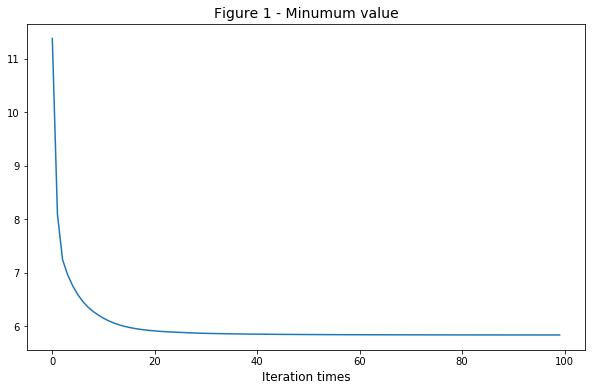

In [179]:
print "Minumun function value: %f" % value[99]

plt.figure(figsize=(10,6))
plt.plot(value)
plt.title('Figure 1 - Minumum value', fontsize=14)
plt.xlabel('Iteration times', fontsize=12)
plt.show()

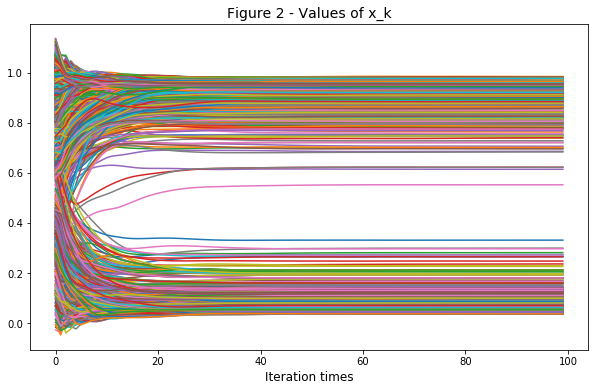

In [138]:
plt.figure(figsize=(10,6))
plt.plot(X)
plt.title('Figure 2 - Values of x', fontsize=14)
plt.xlabel('Iteration times', fontsize=12)
plt.show()

Cette figure montre que les valeurs initiales de x sont distribués entre 0 et 1, mais après quelques itérations, les valeurs sont changés vers soit 0, soit 1. Dans l'image, il signifie que l'image sera plus claire avec plus de itérations.

EQM:  0.00538745981924


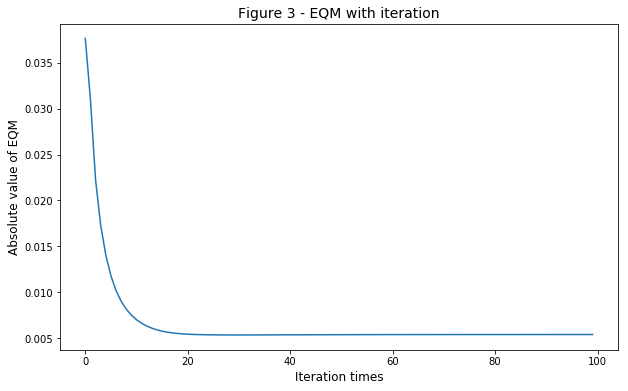

In [182]:
print "EQM: ", EQMs[99]
plt.figure(figsize=(10,6))
plt.plot(EQMs)
plt.title('Figure 3 - EQM with iteration', fontsize=14)
plt.xlabel('Iteration times', fontsize=12)
plt.ylabel('Absolute value of EQM', fontsize=12)
plt.show()

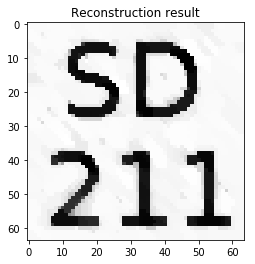

In [147]:
x = X[99].reshape((K,L))
plt.imshow(x, cmap='gray')
plt.title('Reconstruction result')
plt.show()

Ce image après la reconstruction est assez claire par rapport l'observation.

### Manipulation 4
#### 4.1 Varier le paramètre $\rho$

In [188]:
rhos = np.linspace(0.02,0.1,5)
print "Change rho in ", rhos
Biais = [] # 5 * (4096,)
EQMs = [] # 5 * val
Values = [] # 5 * (100)
V_min = []
for rho in rhos:
    value, X, biais, EQM = ADMM(x0, y, rho=rho, beta=0.01, k_max=100)
    V_min.append(value[99])
    Biais.append(biais)
    EQMs.append(EQM[99])
    Values.append(value)

Change rho in  [ 0.02  0.04  0.06  0.08  0.1 ]
100%  ||####################################################################################################->
100%  ||####################################################################################################->
100%  ||####################################################################################################->
100%  ||####################################################################################################->
100%  ||####################################################################################################->


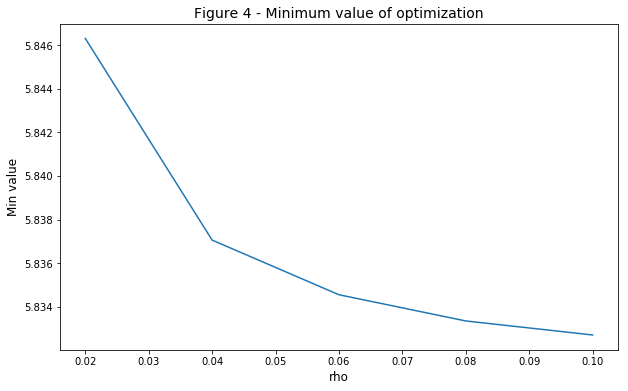

In [189]:
plt.figure(figsize=(10,6))
plt.plot(rhos,V_min)
plt.title('Figure 4 - Minimum value of optimization', fontsize=14)
plt.xlabel('rho', fontsize=12)
plt.ylabel('Min value', fontsize=12)
plt.show()

Avec $\rho$ augmente, le valeur optimal diminuer, signifiant une mieux qualité de la reconstruction.

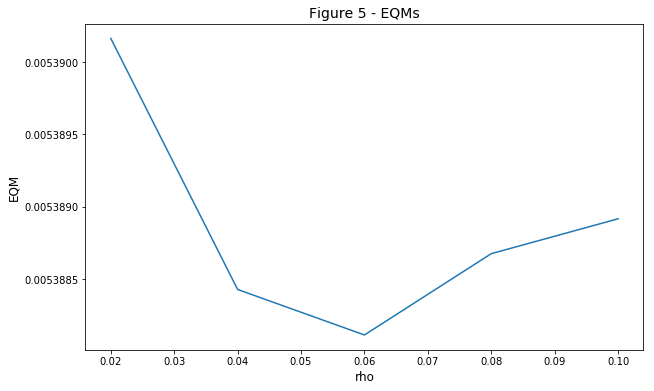

In [190]:
plt.figure(figsize=(10,6))
plt.plot(rhos,EQMs)
plt.title('Figure 5 - EQMs', fontsize=14)
plt.xlabel('rho', fontsize=12)
plt.ylabel('EQM', fontsize=12)
plt.show()

Cette figure signifie que le EQM peut atteindre son minimum près de $\rho = 0.06$.

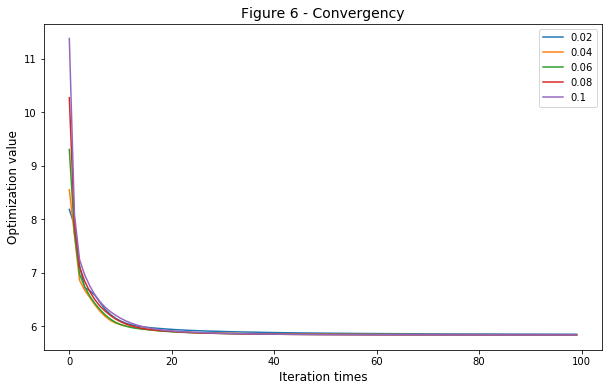

In [191]:
plt.figure(figsize=(10,6))
for (i,rho) in zip(np.arange(5), rhos):
    plt.plot(Values[i])
plt.legend(rhos)
plt.title('Figure 6 - Convergency', fontsize=14)
plt.xlabel('Iteration times', fontsize=12)
plt.ylabel('Optimization value', fontsize=12)
plt.show()

Le problème d'optimisation converge plus rapidement quand $\rho$ est 0.04 et 0.06, mais pas évidemment. La défférence est les valeurs initiales : la valeur initiale est le plus petit quand $\rho$ est plus petit. 

#### 4.2 Varier le paramètre $\beta$

In [193]:
betas = np.linspace(0.005,0.02,4)
print "Change beta in ", betas
Biais_b = [] # 5 * (4096,)
EQMs_b = [] # 5 * val
Values_b = [] # 5 * (100)
V_min_b = []
for beta in betas:
    value, X, biais, EQM = ADMM(x0, y, rho=0.05, beta = beta, k_max=100)
    V_min_b.append(value[99])
    Biais_b.append(biais)
    EQMs_b.append(EQM[99])
    Values_b.append(value)

Change beta in  [ 0.005  0.01   0.015  0.02 ]
100%  ||####################################################################################################->
100%  ||####################################################################################################->
100%  ||####################################################################################################->
100%  ||####################################################################################################->


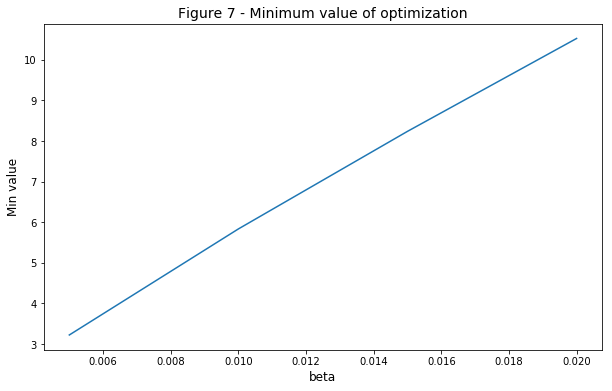

In [194]:
plt.figure(figsize=(10,6))
plt.plot(betas,V_min_b)
plt.title('Figure 7 - Minimum value of optimization', fontsize=14)
plt.xlabel('beta', fontsize=12)
plt.ylabel('Min value', fontsize=12)
plt.show()

En contraire avec $\rho$, l'augmentation de $\beta$ augment la valeur minimale directement.

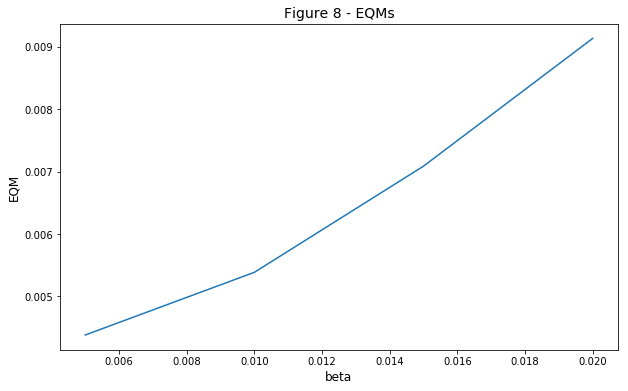

In [197]:
plt.figure(figsize=(10,6))
plt.plot(betas,EQMs_b)
plt.title('Figure 8 - EQMs', fontsize=14)
plt.xlabel('beta', fontsize=12)
plt.ylabel('EQM', fontsize=12)
plt.show()

Cette figure signifie que le EQM augment quand $\beta$ augement.

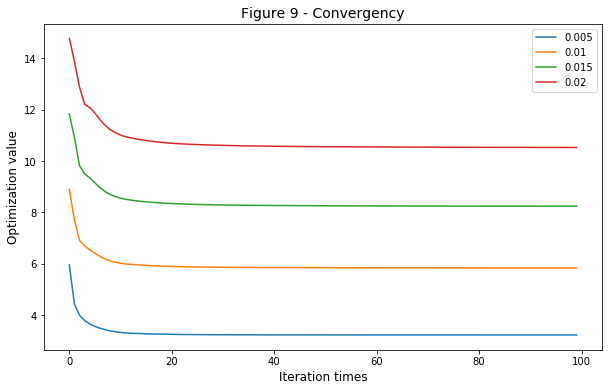

In [198]:
plt.figure(figsize=(10,6))
for (i,beta) in zip(np.arange(4), betas):
    plt.plot(Values_b[i])
plt.legend(betas)
plt.title('Figure 9 - Convergency', fontsize=14)
plt.xlabel('Iteration times', fontsize=12)
plt.ylabel('Optimization value', fontsize=12)
plt.show()

La figure montre que le problème converge plus rapid et peut atteindre une valeur optimale plus petite quand $\beta$ est plus petit.

### Conclusion

Dans ce TP, on fait la restauration d'image comme un problème d'optimisation pour le but de minimiser la différence entre ovservation et l'estimation sachant la matrice de convolution. L'algorithme de l'ADMM avec défferentes $\rho$ et $\beta$ sont discutés et comparés.<br>

Quand $\beta$ est fixé, l'augmentation de $\rho$ dans l'intervalle [0,0.1] peut diminuer le minimiseur du problème de l'optimisation, mais quand $\rho$ est plus grand, le EQM aussi augmente. <br>

Quand $\rho$ est fixé, l'augmentation de $\beta$ dans l'intervalle [0,0.02] augmente évidemment le minimiseur du problème et dans ce problème, $\beta$ signifie la regularisation des décalages horizontaux et verticaux, c'est à dire, dans ce problème là, il faut permettre un grand décalage entre les pixels voisins pour que l'image soit plus 'claire'.